<a href="https://colab.research.google.com/github/mohameddhameem/Learning-and-Planning-in-Intelligent-Systems/blob/main/Question_2_RL_DQN_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q swig

In [ ]:
pip install -q "gymnasium[box2d]"

In [ ]:
from collections import deque
import random
import json
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

In [ ]:
GLOBAL_CONFIG = {
    'env_name': 'LunarLander-v3',
    'max_episode_steps': 1000,
    'num_seeds': 3,
    'seeds': [42, 123, 456],
    'total_steps': 20_000, # 500_000
    'eval_frequency': 10_000,
    'eval_episodes': 10,
    'gamma': 0.99,
    'log_frequency': 1000,
    'moving_avg_window': 100,
    'save_checkpoint': True,
}

DQN_CONFIG = {
    'hidden_layers': [128, 128],
    'activation': 'relu',
    'learning_rate': 5e-4,
    'batch_size': 64,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay_steps': 50_000,
    'buffer_capacity': 100_000,
    'min_buffer_size': 1_000,
    'prefill_steps': 1_000,
    'target_update_frequency': 1000,
    'use_soft_update': True,
    'tau': 0.005,
    'optimizer': 'Adam',
    'gradient_clip': 10.0,
    'gamma': 0.99,
}

REINFORCE_CONFIG = {
    'hidden_layers': [128, 128],
    'activation': 'relu',
    'learning_rate': 3e-3,
    'use_baseline': True,
    'baseline_learning_rate': 1e-3,
    'optimizer': 'Adam',
    'gradient_clip': 1.0,
    'normalize_returns': True,
    'gamma': 0.99,
}

In [ ]:
def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def create_env(seed: int):
    env = gym.make(GLOBAL_CONFIG['env_name'])
    env.reset(seed=seed)
    try:
        env.action_space.seed(seed)
    except Exception:
        pass
    return env


def check_gpu():
    """Check GPU availability and print info."""
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        print(f"GPU Available: {device_name}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        print("⚠ No GPU detected - using CPU (will be slower)")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class QNetwork(nn.Module):
    """Deep Q-Network for value function approximation."""

    def __init__(self, state_dim=8, action_dim=4, hidden_layers=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, action_dim))
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            nn.init.constant_(module.bias, 0)

    def forward(self, state):
        return self.network(state)


class PolicyNetwork(nn.Module):
    """Stochastic policy network for REINFORCE."""

    def __init__(self, state_dim=8, action_dim=4, hidden_layers=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        self.feature_network = nn.Sequential(*layers)
        self.action_head = nn.Linear(input_dim, action_dim)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            nn.init.constant_(module.bias, 0)

    def forward(self, state):
        features = self.feature_network(state)
        logits = self.action_head(features)
        action_probs = F.softmax(logits, dim=-1)
        return action_probs

    def get_action(self, state):
        """Sample action from policy."""
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob


class ValueNetwork(nn.Module):
    """Baseline value network for variance reduction."""

    def __init__(self, state_dim=8, hidden_layers=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=1.0)
            nn.init.constant_(module.bias, 0)

    def forward(self, state):
        return self.network(state).squeeze(-1)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        states = np.array([e[0] for e in batch], dtype=np.float32)
        actions = np.array([e[1] for e in batch], dtype=np.int64)
        rewards = np.array([e[2] for e in batch], dtype=np.float32)
        next_states = np.array([e[3] for e in batch], dtype=np.float32)
        dones = np.array([e[4] for e in batch], dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNAgent:
    """Deep Q-Network with target network and experience replay."""

    def __init__(self, state_dim, action_dim, config, device=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Networks
        self.q_network = QNetwork(state_dim, action_dim, config['hidden_layers']).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, config['hidden_layers']).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config['learning_rate'])

        # Replay buffer
        self.replay_buffer = ReplayBuffer(config['buffer_capacity'])

        # Exploration
        self.epsilon = config['epsilon_start']
        self.epsilon_decay = (config['epsilon_start'] - config['epsilon_end']) / max(1, config['epsilon_decay_steps'])

        # Tracking
        self.steps = 0
        self.episodes = 0

    def select_action(self, state, evaluation=False):
        if evaluation or np.random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax(dim=1).item()
        else:
            action = np.random.randint(self.action_dim)

        return action

    def update(self):
        if len(self.replay_buffer) < self.config['min_buffer_size']:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.config['batch_size'])

        states = torch.FloatTensor(states).to(self.device, non_blocking=True)
        actions = torch.LongTensor(actions).to(self.device, non_blocking=True)
        rewards = torch.FloatTensor(rewards).to(self.device, non_blocking=True)
        next_states = torch.FloatTensor(next_states).to(self.device, non_blocking=True)
        dones = torch.FloatTensor(dones).to(self.device, non_blocking=True)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q = self.target_network(next_states).max(dim=1)[0]
            target_q = rewards + (1 - dones) * self.config['gamma'] * next_q

        loss = nn.functional.smooth_l1_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), self.config['gradient_clip'])
        self.optimizer.step()

        if self.config['use_soft_update']:
            self._soft_update_target()
        elif self.steps % self.config['target_update_frequency'] == 0:
            self._hard_update_target()

        self.epsilon = max(self.config['epsilon_end'], self.epsilon - self.epsilon_decay)

        return loss.item()

    def _soft_update_target(self):
        tau = self.config['tau']
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def _hard_update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        self.steps += 1

In [ ]:
class REINFORCEAgent:
    """REINFORCE with reward-to-go and optional baseline."""

    def __init__(self, state_dim, action_dim, config, device=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Policy and (optional) value network
        self.policy = PolicyNetwork(state_dim, action_dim, config['hidden_layers']).to(self.device)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=config['learning_rate'])

        if config.get('use_baseline'):
            self.value_net = ValueNetwork(state_dim, config['hidden_layers']).to(self.device)
            self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=config['baseline_learning_rate'])
        else:
            self.value_net = None

        self.reset_episode()
        self.steps = 0
        self.episodes = 0

    def reset_episode(self):
        self.episode_states = []
        self.episode_actions = []
        self.episode_log_probs = []
        self.episode_rewards = []

    def select_action(self, state, evaluation=False):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if evaluation:
            with torch.no_grad():
                probs = self.policy(state_tensor)
                action = probs.argmax(dim=1).item()
            return action
        else:
            action, log_prob = self.policy.get_action(state_tensor)
            return action, log_prob

    def store_transition(self, state, action, log_prob, reward):
        self.episode_states.append(state)
        self.episode_actions.append(action)
        self.episode_log_probs.append(log_prob)
        self.episode_rewards.append(reward)
        self.steps += 1

    def _compute_returns(self):
        """✅ FIXED: Use config gamma properly"""
        returns = []
        G = 0
        gamma = self.config['gamma']
        for reward in reversed(self.episode_rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        return returns

    def update(self):
        if len(self.episode_rewards) == 0:
            return None

        returns = self._compute_returns()

        states = torch.FloatTensor(np.array(self.episode_states)).to(self.device, non_blocking=True)
        log_probs = torch.stack(self.episode_log_probs)
        returns = torch.FloatTensor(returns).to(self.device, non_blocking=True)

        if self.config.get('normalize_returns') and len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        if self.value_net is not None:
            with torch.no_grad():
                values = self.value_net(states)
            advantages = returns - values

            value_loss = nn.functional.mse_loss(self.value_net(states), returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            nn.utils.clip_grad_norm_(self.value_net.parameters(), self.config['gradient_clip'])
            self.value_optimizer.step()
        else:
            advantages = returns

        policy_loss = -(log_probs * advantages).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), self.config['gradient_clip'])
        self.policy_optimizer.step()

        loss = policy_loss.item()
        self.reset_episode()
        self.episodes += 1
        return loss

In [ ]:
def plot_learning_curves(dqn_results, reinforce_results, window=100):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # DQN
    ax = axes[0]
    for result in dqn_results:
        steps = result['episode_steps']
        returns = result['episode_returns']
        if len(returns) == 0:
            continue
        smoothed = uniform_filter1d(returns, size=min(window, len(returns)))
        ax.plot(steps, smoothed, alpha=0.7, label=f"Seed {result['seed']}")

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return (Moving Avg)', fontsize=12)
    ax.set_title('DQN Learning Curve', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Solved (200)')

    # REINFORCE
    ax = axes[1]
    for result in reinforce_results:
        steps = result['episode_steps']
        returns = result['episode_returns']
        if len(returns) == 0:
            continue
        smoothed = uniform_filter1d(returns, size=min(window, len(returns)))
        ax.plot(steps, smoothed, alpha=0.7, label=f"Seed {result['seed']}")

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return (Moving Avg)', fontsize=12)
    ax.set_title('REINFORCE Learning Curve', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Solved (200)')

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    print("✓ Learning curves saved to 'learning_curves.png'")
    plt.show()


def compute_statistics(results, threshold=200):
    final_returns = []
    steps_to_threshold = []

    for result in results:
        returns = result['episode_returns']
        steps = result['episode_steps']

        if len(returns) == 0:
            continue  # Skip empty results

        # Final performance
        final_window = min(100, len(returns))
        final_returns.append(np.mean(returns[-final_window:]))

        # Steps to threshold
        if len(returns) >= 100:
            smoothed = uniform_filter1d(returns, size=100)
            threshold_indices = np.where(smoothed >= threshold)[0]
            if len(threshold_indices) > 0:
                steps_to_threshold.append(steps[threshold_indices[0]])
            else:
                steps_to_threshold.append(None)
        else:
            steps_to_threshold.append(None)

    # ✅ FIXED: Handle case where all values are None
    valid_steps = [s for s in steps_to_threshold if s is not None]

    stats = {
        'final_return_mean': np.mean(final_returns) if final_returns else 0.0,
        'final_return_std': np.std(final_returns) if final_returns else 0.0,
        'steps_to_threshold_mean': np.mean(valid_steps) if valid_steps else float('inf'),
        'steps_to_threshold_std': np.std(valid_steps) if len(valid_steps) > 1 else 0.0,
        'solved_seeds': len(valid_steps),
        'total_seeds': len(results)
    }
    return stats


def generate_report(dqn_results, reinforce_results):
    dqn_stats = compute_statistics(dqn_results)
    reinforce_stats = compute_statistics(reinforce_results)

    # Format steps with proper handling of inf
    dqn_steps_str = f"{dqn_stats['steps_to_threshold_mean']:.0f}" if dqn_stats['steps_to_threshold_mean'] != float('inf') else "N/A (not reached)"
    dqn_steps_std_str = f" ± {dqn_stats['steps_to_threshold_std']:.0f}" if dqn_stats['steps_to_threshold_std'] > 0 else ""

    reinforce_steps_str = f"{reinforce_stats['steps_to_threshold_mean']:.0f}" if reinforce_stats['steps_to_threshold_mean'] != float('inf') else "N/A (not reached)"
    reinforce_steps_std_str = f" ± {reinforce_stats['steps_to_threshold_std']:.0f}" if reinforce_stats['steps_to_threshold_std'] > 0 else ""

    # Determine winner for sample efficiency
    if dqn_stats['steps_to_threshold_mean'] == float('inf') and reinforce_stats['steps_to_threshold_mean'] == float('inf'):
        efficiency_winner = "Neither (both didn't reach threshold)"
    elif dqn_stats['steps_to_threshold_mean'] == float('inf'):
        efficiency_winner = "REINFORCE"
    elif reinforce_stats['steps_to_threshold_mean'] == float('inf'):
        efficiency_winner = "DQN"
    else:
        efficiency_winner = 'DQN' if dqn_stats['steps_to_threshold_mean'] < reinforce_stats['steps_to_threshold_mean'] else 'REINFORCE'

    report = f"""
{'='*60}
COMPARISON REPORT: DQN vs REINFORCE
{'='*60}

1. FINAL PERFORMANCE (last 100 episodes)
{'-'*60}
DQN:
  Mean Return: {dqn_stats['final_return_mean']:.2f} ± {dqn_stats['final_return_std']:.2f}
  Seeds Solved: {dqn_stats['solved_seeds']}/{dqn_stats['total_seeds']}

REINFORCE:
  Mean Return: {reinforce_stats['final_return_mean']:.2f} ± {reinforce_stats['final_return_std']:.2f}
  Seeds Solved: {reinforce_stats['solved_seeds']}/{reinforce_stats['total_seeds']}

Winner: {'DQN' if dqn_stats['final_return_mean'] > reinforce_stats['final_return_mean'] else 'REINFORCE'}

2. SAMPLE EFFICIENCY (steps to reach 200 reward)
{'-'*60}
DQN:
  Mean Steps: {dqn_steps_str}{dqn_steps_std_str}

REINFORCE:
  Mean Steps: {reinforce_steps_str}{reinforce_steps_std_str}

More Efficient: {efficiency_winner}

3. STABILITY
{'-'*60}
DQN Variance: {dqn_stats['final_return_std']:.2f}
REINFORCE Variance: {reinforce_stats['final_return_std']:.2f}

More Stable: {'DQN' if dqn_stats['final_return_std'] < reinforce_stats['final_return_std'] else 'REINFORCE'}

{'='*60}
"""
    return report

In [ ]:
def train_dqn(env, agent, config, seed):
    episode_returns = []
    episode_steps_list = []
    losses = []

    state, _ = env.reset(seed=seed)
    episode_return = 0
    episode_steps = 0

    pbar = tqdm(total=config['total_steps'], desc=f"DQN (seed={seed})")

    for step in range(config['total_steps']):
        if step < config['prefill_steps']:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.store_transition(state, action, reward, next_state, terminated)

        if step >= config['prefill_steps']:
            loss = agent.update()
            if loss is not None:
                losses.append(loss)

        episode_return += reward
        episode_steps += 1
        state = next_state

        if done:
            episode_returns.append(episode_return)
            episode_steps_list.append(step + 1)
            state, _ = env.reset()
            episode_return = 0
            episode_steps = 0

        if step % 100 == 0:
            pbar.update(100)
            pbar.set_postfix({
                'eps': len(episode_returns),
                'ret': f"{episode_returns[-1]:.1f}" if episode_returns else "0",
                'ε': f"{agent.epsilon:.3f}"
            })

    pbar.close()

    return {
        'episode_returns': episode_returns,
        'episode_steps': episode_steps_list,
        'losses': losses,
        'seed': seed
    }


In [ ]:
def train_reinforce(env, agent, config, seed):
    episode_returns = []
    episode_steps_list = []
    losses = []

    total_steps = 0
    pbar = tqdm(total=config['total_steps'], desc=f"REINFORCE (seed={seed})")

    while total_steps < config['total_steps']:
        state, _ = env.reset()
        episode_return = 0
        episode_steps = 0

        while True:
            action, log_prob = agent.select_action(state, evaluation=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.store_transition(state, action, log_prob, reward)

            episode_return += reward
            episode_steps += 1
            total_steps += 1
            state = next_state

            if done:
                break

        loss = agent.update()
        if loss is not None:
            losses.append(loss)

        episode_returns.append(episode_return)
        episode_steps_list.append(total_steps)

        pbar.update(episode_steps)
        pbar.set_postfix({
            'eps': len(episode_returns),
            'ret': f"{episode_returns[-1]:.1f}",
            'avg': f"{np.mean(episode_returns[-100:]):.1f}"
        })

    pbar.close()

    return {
        'episode_returns': episode_returns,
        'episode_steps': episode_steps_list,
        'losses': losses,
        'seed': seed
    }

In [ ]:
def evaluate_agent(env, agent, num_episodes=10):
    """Evaluate agent without exploration."""
    returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_return = 0
        while True:
            action = agent.select_action(state, evaluation=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_return += reward
            state = next_state
            if terminated or truncated:
                break
        returns.append(episode_return)
    return np.mean(returns), np.std(returns)

GPU Available: Tesla T4
CUDA Version: 12.6
Memory: 15.83 GB
Training DQN


DQN (seed=456): 100%|██████████| 20000/20000 [00:57<00:00, 349.40it/s, eps=209, ret=-36.6, ε=0.626]



Training REINFORCE


REINFORCE (seed=42): 20024it [00:39, 502.36it/s, eps=256, ret=-578.5, avg=-332.8]
REINFORCE (seed=123): 20010it [00:37, 539.64it/s, eps=140, ret=-725.6, avg=-721.7]
REINFORCE (seed=456): 20003it [00:37, 534.60it/s, eps=224, ret=-134.7, avg=-136.0]



Saving Results
✓ DQN results saved to 'dqn_results.json'
✓ REINFORCE results saved to 'reinforce_results.json'

Generating Visualizations
✓ Learning curves saved to 'learning_curves.png'


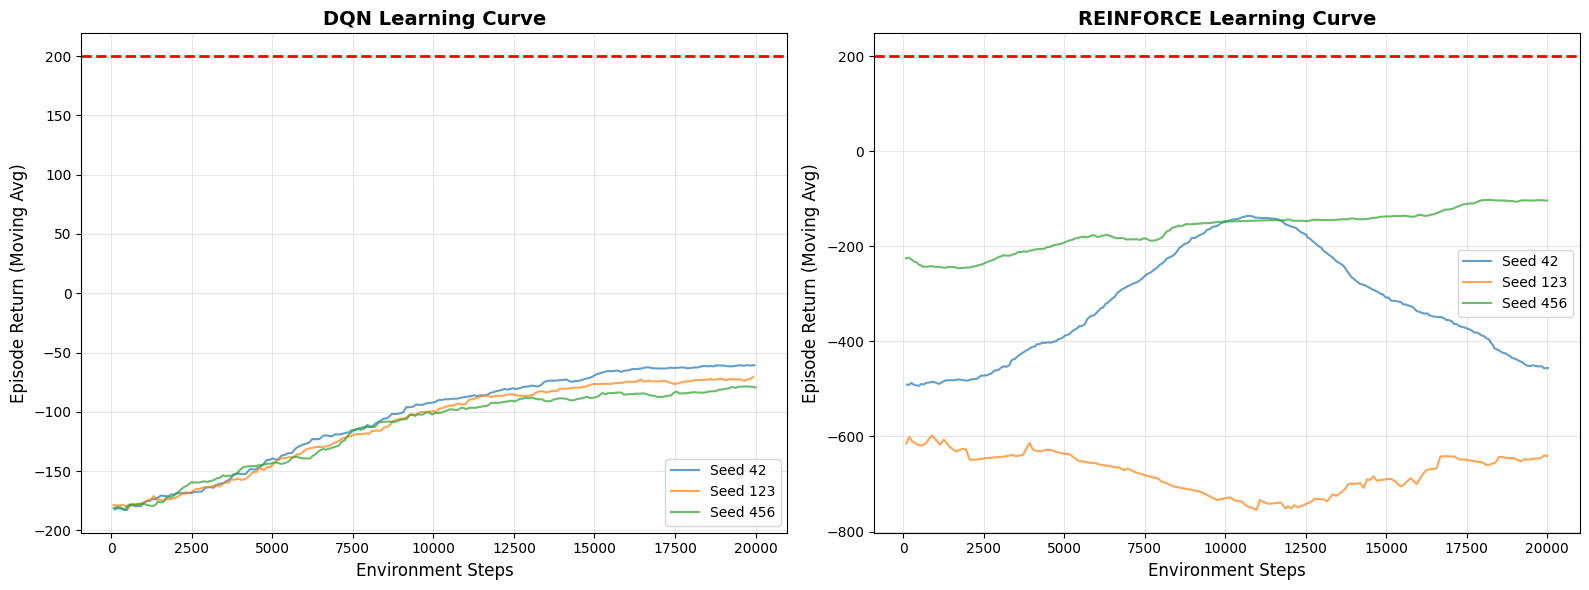


Analysis Report

COMPARISON REPORT: DQN vs REINFORCE

1. FINAL PERFORMANCE (last 100 episodes)
------------------------------------------------------------
DQN:
  Mean Return: -77.98 ± 7.29
  Seeds Solved: 0/3

REINFORCE:
  Mean Return: -396.86 ± 243.34
  Seeds Solved: 0/3

Winner: DQN

2. SAMPLE EFFICIENCY (steps to reach 200 reward)
------------------------------------------------------------
DQN:
  Mean Steps: N/A (not reached)

REINFORCE:
  Mean Steps: N/A (not reached)

More Efficient: Neither (both didn't reach threshold)

3. STABILITY
------------------------------------------------------------
DQN Variance: 7.29
REINFORCE Variance: 243.34

More Stable: DQN


✓ Report saved to 'comparison_report.txt'

✓ Training complete! All results saved.


In [ ]:
device = check_gpu()
print('='*60)
print('Training DQN')
print('='*60)
dqn_results = []
for seed in GLOBAL_CONFIG['seeds']:
    set_seed(seed)
    env = create_env(seed)
    agent = DQNAgent(8, 4, {**GLOBAL_CONFIG, **DQN_CONFIG}, device=device)
    results = train_dqn(env, agent, {**GLOBAL_CONFIG, **DQN_CONFIG}, seed)
    dqn_results.append(results)
    env.close()

# Clear GPU cache between seeds
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print('\n' + '='*60)
print('Training REINFORCE')
print('='*60)
reinforce_results = []
for seed in GLOBAL_CONFIG['seeds']:
    set_seed(seed)
    env = create_env(seed)
    agent = REINFORCEAgent(8, 4, {**GLOBAL_CONFIG, **REINFORCE_CONFIG}, device=device)
    results = train_reinforce(env, agent, {**GLOBAL_CONFIG, **REINFORCE_CONFIG}, seed)
    reinforce_results.append(results)
    env.close()

    # Clear GPU cache between seeds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save results
print('\n' + '='*60)
print('Saving Results')
print('='*60)

with open('dqn_results.json', 'w') as f:
    json.dump(dqn_results, f, indent=2)
print("✓ DQN results saved to 'dqn_results.json'")

with open('reinforce_results.json', 'w') as f:
    json.dump(reinforce_results, f, indent=2)
print("✓ REINFORCE results saved to 'reinforce_results.json'")

# Generate plots
print('\n' + '='*60)
print('Generating Visualizations')
print('='*60)
try:
    plot_learning_curves(dqn_results, reinforce_results)
except Exception as e:
    print(f"⚠ Could not generate plots: {e}")

# Generate report
print('\n' + '='*60)
print('Analysis Report')
print('='*60)
report = generate_report(dqn_results, reinforce_results)
print(report)

# Save report
with open('comparison_report.txt', 'w') as f:
    f.write(report)
print("✓ Report saved to 'comparison_report.txt'")

print('\n' + '='*60)
print('✓ Training complete! All results saved.')
print('='*60)